# Classifying Pulsar Candidates Using a K-NN Algorithm

## Introduction
- Pulsars are rotating neutron stars observed to have pulses of radiation at very regular intervals, typically ranging from milliseconds to seconds. These accelerated particles produce very powerful beams of light, with some pulsars producing enough radio emissions to be detected on Earth (Ng et al., 2015).
- Detection of Pulsars is a complex task and involves discerning fleeting Pulsar signals from a copious amount of background radio frequency interference (Eatough et al., 2010). To aid in the detection of Pulsars, computer algorithms can speed up the process and accuracy. Within our project, we aim to create a supervised *K*-Nearest Neighbors algorithm in the binary classification of the Pulsar star state.



**Predictive question:** Can we create a *K*-nearest neighbor algorithm capable of classifying whether an observation is a Pulsar star or not, given the kurtosis and skewness of the integrated profile, as well as the mean, kurtosis, and skewness of the DM-SNR curve?


#### Dataset
- The data set that we use describes a sample of pulsar candidates collected as part of the High Time Resolution Universe Survey of the southern hemisphere.
- The data set contains a total of 8 different features and 1 class variable. The variables are measures of the dispersion measure-signal-to-noise ratio (DM-SNR) or the integrated profile of each recorded observation.

## Exploratory data analysis

In [1]:
# Importing libraries and setting seed
library(tidyverse)
library(tidymodels)
install.packages("themis") 


set.seed(100)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

#### Reading and wrangling the data from internet:

First, we create two helper functions to keep track of the table numbers and graph number

In [2]:
table_count <- 0
print_table_legend <- function(text) {
    table_count <<- table_count + 1
    print(paste("Table", table_count,":",text))
}

graph_count <- 0
print_graph_count <- function() {
    graph_count <<- graph_count + 1
    print(paste("Graph -", graph_count))
}

Since the initial data file is in a zip folder, we created a new repository on github, and utilized the raw link to demonstrate that the data can be read from the web. Then, we wrangle and clean the data. First, we rename the columns to give them descriptive names.  Since we are interested in predicting the class of the star, we convert the class column to the type factor. Then, we select only the required columns (Profile_skewness, Profile_kurtosis, DM_mean, DM_skewness, DM_kurtosis, Class) and we remove the rest

In [3]:

pulsar_df <- read_csv("https://raw.githubusercontent.com/MichaelZhang33/HTRU21.csv/main/HTRU_2.arff", 
                       skip = 11, col_names = FALSE) |>
     rename("Profile_mean" = X1,
        "Profile_stdev" = X2,
        "Profile_skewness" = X3,
        "Profile_kurtosis" = X4,
        "DM_mean" = X5, 
        "DM_stdev" = X6, 
        "DM_skewness" = X7,
        "DM_kurtosis" = X8,
        "class" = X9) |>
    mutate(class = as_factor(class)) |>
    mutate(Class = fct_recode(class, "notpulsar" = "0", "pulsar" = "1")) |>
    select(-Profile_mean, -Profile_stdev, -DM_stdev, -class)

head(pulsar_df)
print_table_legend("Wrangled and cleaned data for analysis")

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Profile_skewness,Profile_kurtosis,DM_mean,DM_skewness,DM_kurtosis,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.23457141,-0.6996484,3.199833,7.975532,74.24222,notpulsar
0.46531815,-0.5150879,1.677258,10.576487,127.39358,notpulsar
0.32332837,1.0511644,3.121237,7.735822,63.17191,notpulsar
-0.06841464,-0.6362384,3.642977,6.896499,53.59366,notpulsar
0.60086608,1.1234917,1.178930,14.269573,252.56731,notpulsar
0.53190485,0.4167211,1.636288,10.621748,131.39400,notpulsar


[1] "Table 1 : Wrangled and cleaned data for analysis"


Now, we split the data into training and testing data. We train our model using 75% of the data, and test with the other 25% of the data. We stratify our data based on `Class`, because that is what we are interested in predicting

In [4]:
# Splitting the dataset into a training and testing set
pulsar_split <- initial_split(pulsar_df, prop = 0.75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### Useful Tabular Data

##### 1. Summary table for the number of pulsar star observations and non-pulsar star observations in the training set:

In [5]:
useful_df_1 <- pulsar_train |>
    group_by(Class) |>
    summarize(count = n())
useful_df_1


print_table_legend("Number of pulsars and non-pulsars in the data set")

Class,count
<fct>,<int>
notpulsar,12182
pulsar,1241


[1] "Table 2 : Number of pulsars and non-pulsars in the data set"


These results indicate that the dataset is not balanced, and classification algorithms can perform badly when trained on imbalanced datasets. Oversampling can be a useful way of overcoming the class imbalance and hence improving the model’s performance. Hence, will require oversampling of the positive pulsar cases when creating the model.

In [6]:
library(themis)
balance_recipe <- recipe(Class ~ ., data = pulsar_train) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
    prep()

pulsar_train <- bake(balance_recipe, pulsar_train)
pulsar_train |>
    group_by(Class) |>
    summarize(n = n())

Class,n
<fct>,<int>
notpulsar,12182
pulsar,12182


##### 2. Summary table for the average value of each predictor variable based on class:

In [7]:
useful_df_2 <- pulsar_train |>
    group_by(Class) |>
    summarize(mean_profile_skewness = mean(Profile_skewness), 
              mean_profile_kurtosis = mean(Profile_kurtosis), 
              mean_DM_mean = mean(DM_mean), 
              mean_DM_skewness = mean(DM_skewness), 
              mean_DM_kurtosis = mean(DM_kurtosis))
useful_df_2
print_table_legend("Average value of each predictor in the data set")

Class,mean_profile_skewness,mean_profile_kurtosis,mean_DM_mean,mean_DM_skewness,mean_DM_kurtosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
notpulsar,0.2118807,0.385433,8.712282,8.899551,114.56026
pulsar,3.1286256,15.437317,51.057610,2.737057,18.40868


[1] "Table 3 : Average value of each predictor in the data set"


##### 3. Number of rows in each column that have na values:

In [8]:
useful_df_3 <- colSums(is.na(pulsar_train))
useful_df_3
print_table_legend("Number of n/a values in the table")

Profile_skewness Profile_kurtosis          DM_mean      DM_skewness 
               0                0                0                0 
     DM_kurtosis            Class 
               0                0

[1] "Table 4 : Number of n/a values in the table"


### Useful visualisations

#### 1. Distribution of Profile_skewness

[1] "Graph - 1"


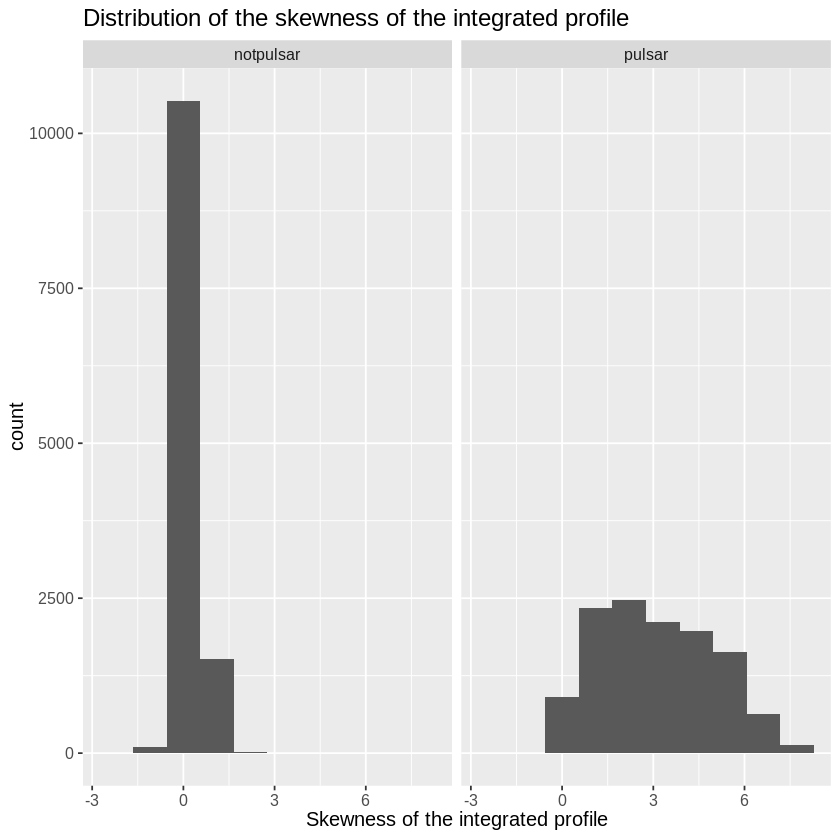

In [9]:
profile_sk_distribution <- pulsar_train |>
    select(Profile_skewness, Class) |>
    ggplot(aes(x = Profile_skewness)) +
    geom_histogram(bins = 10) +
    labs(x= "Skewness of the integrated profile") +
    ggtitle("Distribution of the skewness of the integrated profile") +
    theme(text = element_text(size = 12)) +
    facet_grid(cols = vars(Class))
profile_sk_distribution

print_graph_count()

#### 2. Distribution of Profile_kurtosis

[1] "Graph - 2"


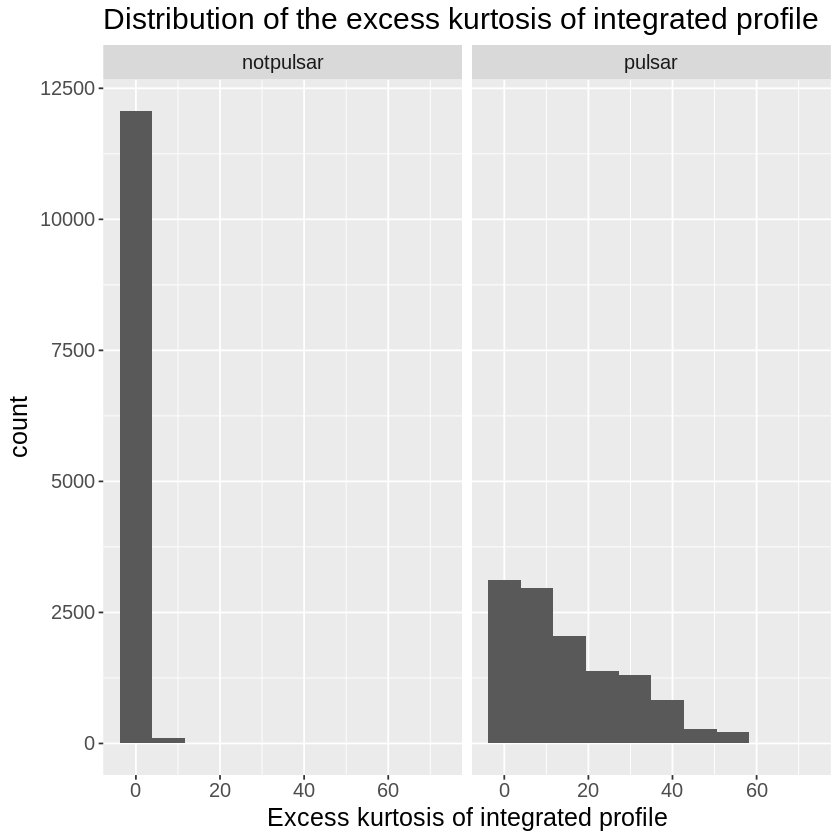

In [10]:
profile_kur_distribution <- pulsar_train |>
    select(Profile_kurtosis, Class) |>
    ggplot(aes(x = Profile_kurtosis)) +
    geom_histogram(bins = 10) +
    labs(x= "Excess kurtosis of integrated profile") +
    ggtitle("Distribution of the excess kurtosis of integrated profile") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_kur_distribution
print_graph_count()

#### 3. Distribution of DM_mean

[1] "Graph - 3"


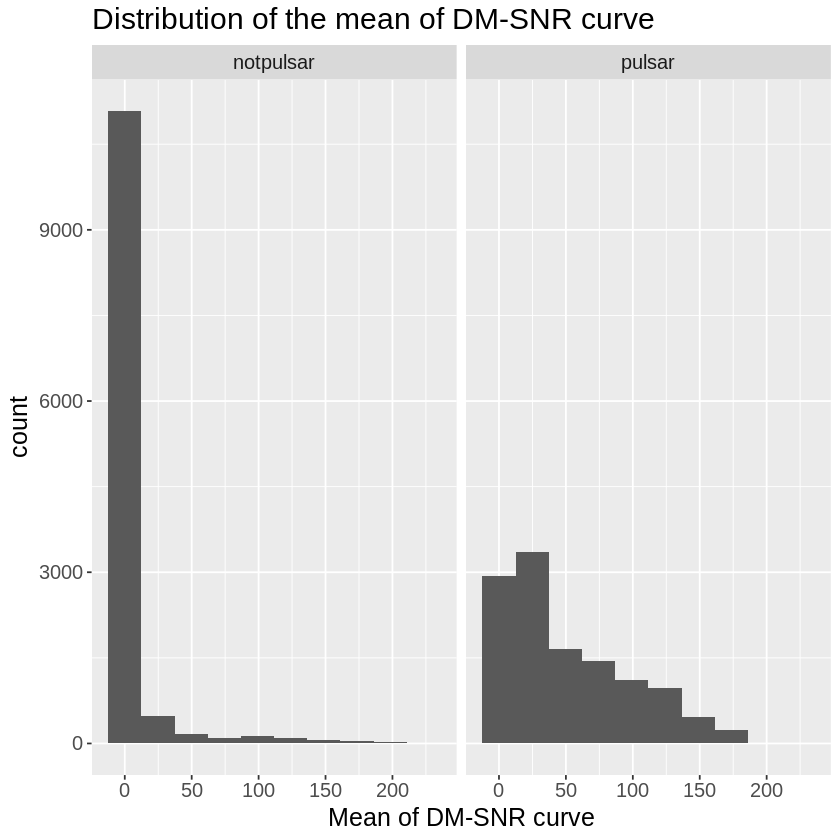

In [11]:
profile_dmMean_distribution <- pulsar_train |>
    select(DM_mean, Class) |>
    ggplot(aes(x = DM_mean)) +
    geom_histogram(bins = 10) +
    labs(x= "Mean of DM-SNR curve") +
    ggtitle("Distribution of the mean of DM-SNR curve") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_dmMean_distribution
print_graph_count()

#### 4. Distribution of DM_skewness

[1] "Graph - 4"


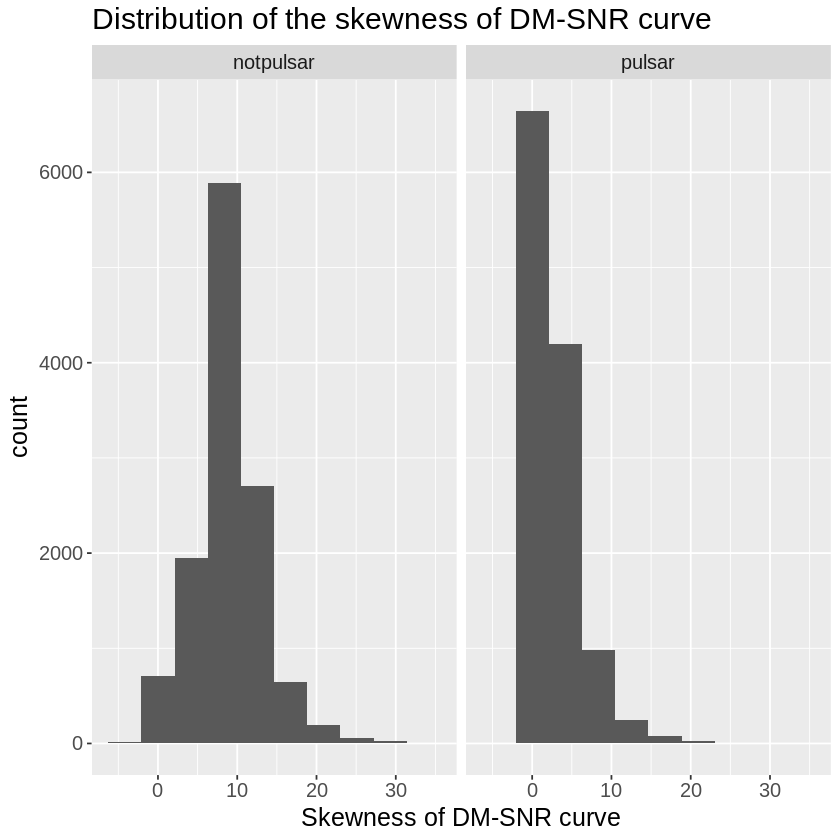

In [12]:
profile_dmsk_distribution <- pulsar_train |>
    select(DM_skewness, Class) |>
    ggplot(aes(x = DM_skewness)) +
    geom_histogram(bins = 10) +
    labs(x= "Skewness of DM-SNR curve") +
    ggtitle("Distribution of the skewness of DM-SNR curve") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_dmsk_distribution
print_graph_count()

#### 5. Distribution of DM_kurtosis

[1] "Graph - 5"


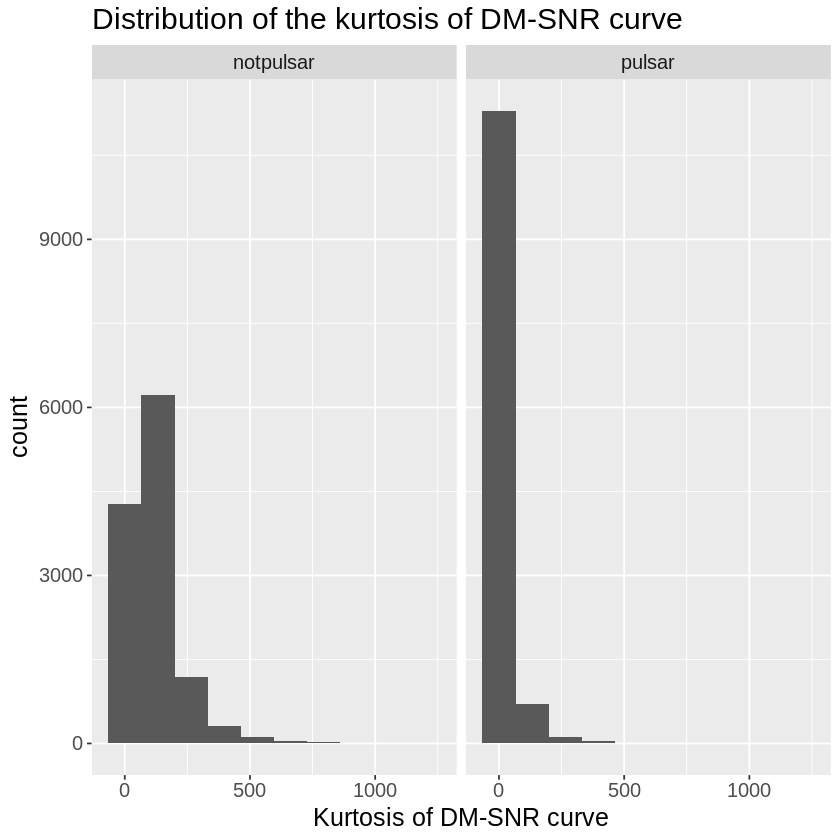

In [13]:
profile_dmKur_distribution <- pulsar_train |>
    select(DM_kurtosis, Class) |>
    ggplot(aes(x = DM_kurtosis)) +
    geom_histogram(bins = 10) +
    labs(x= "Kurtosis of DM-SNR curve") +
    ggtitle("Distribution of the kurtosis of DM-SNR curve") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_dmKur_distribution
print_graph_count()

## Methods and Results

### Methods
To answer our question, we will utilize some of the columns from the initial dataset. These include:
 
1. The excess kurtosis of the integrated profile (*Profile_kurtosis*)
2. The skewness of the integrated profile (*Profile_skewness*)
3. Mean of the DM-SNR curve (*DM_mean*)
4. Excess kurtosis of the DM-SNR curve (*DM_kurtosis*)
5. Skewness of the DM-SNR curve (*DM_skewness*)
6. Observation Class (the outcome variable)

Using the first 5 columns, we will predict through *classification* to determine the observation class.
These variables were chosen based on the nature of Pulsar stars as powerful yet fleeting signals, where the kurtosis and skewness of the integrated profile will help distinguish the transient nature of the star. Furthermore, the DM-SNR mean, kurtosis and skewness will indicate the strength and nature of the signal in comparison to background noise and radio frequency interference.


**Visualisation:** We will visualize our results by creating a confusion matrix to visualize the performance of the model. Furthermore, we will utilize histogram to visualize the relationship between the predictor variables. 

### Results

First we create a workflow to make our model. We will use 20 values of K, lying between K=1 to K=100, and find the best value of K for our model. Then, we perform 5-fold validation, which improves the choice of K as well.

In [14]:
options(repr.plot.height = 5, repr.plot.width = 6)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_recipe <- recipe(Class ~ ., data = pulsar_train)
knn_vfold <- vfold_cv(pulsar_train, v = 5, strata = Class)

knn_wkflw <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics()


In [15]:
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies
print("Table : Accuracy of classifier for each K-value in range 1 to 100")

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9893695,5,0.0010674921,Preprocessor1_Model01
6,accuracy,binary,0.9753734,5,0.0010609208,Preprocessor1_Model02
11,accuracy,binary,0.9566982,5,0.0011374946,Preprocessor1_Model03
16,accuracy,binary,0.9495567,5,0.0020498391,Preprocessor1_Model04
21,accuracy,binary,0.9468068,5,0.0017251392,Preprocessor1_Model05
26,accuracy,binary,0.9458217,5,0.0014774027,Preprocessor1_Model06
31,accuracy,binary,0.9452057,5,0.0013571328,Preprocessor1_Model07
36,accuracy,binary,0.9438923,5,0.0008497481,Preprocessor1_Model08
41,accuracy,binary,0.9437693,5,0.0005662123,Preprocessor1_Model09


[1] "Table : Accuracy of classifier for each K-value in range 1 to 100"


Now, we create a graph to plot the accuracies of our model for each value of K

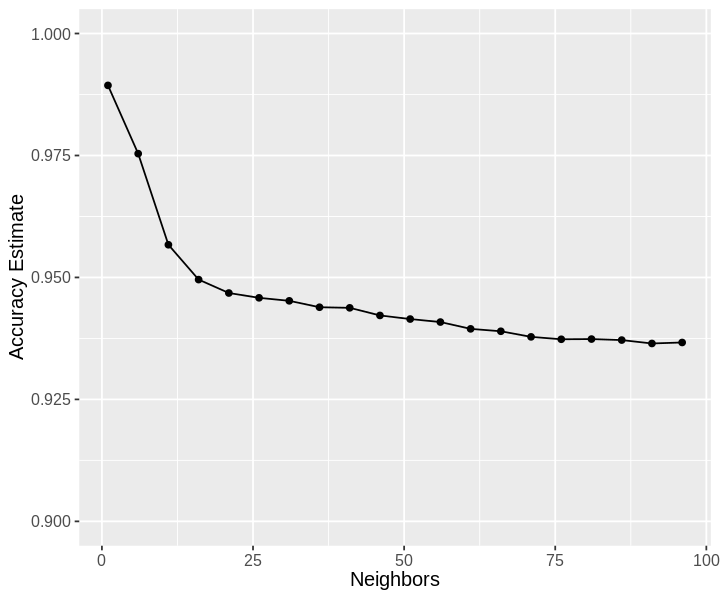

In [16]:
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  ylim(0.90, 1) +
  theme(text = element_text(size = 12))

cross_val_plot

Clearly, the accuracy is highest for $K=1$, but choosing $K=1$ will lead to overfitting. Also, the value of accuracy changes a lot for $K<25$. Because of these reasons, we will choose $K=30$, because the accuracy is fairly high ($95%$), and changing the value of $K$ does not change the the accuracy by a large amount.

In [17]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(final_spec) |>
  fit(data = pulsar_train)

pulsar_predictions <- predict(final_fit, pulsar_test) |>
    bind_cols(pulsar_test)

In [18]:
mnist_conf_mat <- pulsar_predictions |>
     conf_mat(truth = Class, estimate = .pred_class)
mnist_conf_mat

           Truth
Prediction  notpulsar pulsar
  notpulsar      3904     35
  pulsar          173    363

In [19]:
mnist_accuracy <- pulsar_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    pull(.estimate)
mnist_accuracy

[1] 0.9535196

Since we are interested in predicting pulsars, we will assume that "pulsar" classification is the "positive" class

In [20]:
pulsar_predictions |> pull(Class) |> levels()

[1] "notpulsar" "pulsar"

Now, we calculate the precision and recall of our model:

In [21]:
precision <- pulsar_predictions |> 
    precision(truth = Class, estimate = .pred_class, event_level = "second") |> 
    pull(.estimate)

print(paste("Precision:", precision)) 

[1] "Precision: 0.677238805970149"


Calculating the recall of our model:

In [22]:
recall <- pulsar_predictions |> 
    recall(truth = Class, estimate = .pred_class, event_level = "second") |> 
    pull(.estimate)
print(paste("Recall", recall))   

[1] "Recall 0.912060301507538"


## Discussion

### Summary
From our analysis of the data set, using K nearest neighbour (KNN) algorithm, we found out that K=30 neighbours gives the optimal accuracy for our model. Our model has a high recall of 91%, and since models with high recall usually have low precision, the precision of our model is a modest 67%

### Were these results what we expected?
Currently, most ML algorithms that are used to detect pulsars have an accuracy of above 90% (Rong Song, 2023). Hence, we were expecting our model to have an accuacy of above 90% as well. Our model, which uses the K-nearest neighbour (KNN) algorithm and uses 5 variables, has an accuracy of 95%, just as we expected

### Impacts of our finding

This data analysis can help scientists in classifying if an observation is a Pulsar star, a matter of great scientific interest due to the nature of the stars as gravitational probes.

### Future questions this data analysis could lead to:

- Are there any other factors that can help in determining whether an observation is a Pulsar star?
- Are there other algorithms that may be more effective in classifying Pulsar status compared to K-NN?

#### <center> References </center>
Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17082.x


Ng, C., Champion, D. J., Bailes, M., Barr, E. D., Bates, S. D., Bhat, N. D. R., Burgay, M., Burke-Spolaor, S., Flynn, C. M. L., Jameson, A., Johnston, S., Keith, M. J., Kramer, M., Levin, L., Petroff, E., Possenti, A., Stappers, B. W., van Straten, W., Tiburzi, C., & Eatough, R. P. (2015). The High Time Resolution Universe Pulsar Survey – XII. Galactic plane acceleration search and the discovery of 60 pulsars. Monthly Notices of the Royal Astronomical Society, 450(3), 2922–2947. https://doi.org/10.1093/mnras/stv75 <br> <br>3
Galli, S. (2023, November 3). Exploring Oversampling Techniques for Imbalanced Datasets. Train in Data Blog. https://www.blog.trainindata.com/oversampling-techniques-for-imbalanced-data/#:~:text=Oversampling%20is%20a%20data%20augmentation,samples%20in%20the%20minority%20clas 
<br><br>
Song, J. R. (2023). The effectiveness of different machine learning algorithms in classifying pulsar stars and the impact of data preparation. Journal of Physics: Conference Series, 2428(1), 012046. https://doi.org/10.1088/1742-6596/2428/1/012046
